In [44]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
ratings = pd.read_csv('./drive/MyDrive/imdb-rating/ml_detail.csv', sep=',', encoding='latin-1')

In [67]:
ratings.head()

,movie id,user id,rating,content,date,movie index,user index
0,tt0102813,ur0391152,2,I've always had kind of a perverse curiosity a...,22 August 2010,6914,81
1,tt0387808,ur0391152,5,20th Century Fox was moronic not to release th...,6 November 2006,3393,81
2,tt0845046,ur0391152,5,It's the kind of movie that reminds me that th...,28 September 2008,3507,81
3,tt0113824,ur0391152,5,"A very moving animÃ© film from Studio Ghibli, ...",29 September 2003,3181,81
4,tt0455538,ur0391152,2,Based on the autobiographical tale of writer T...,6 October 2008,4699,81


In [68]:
ratings = ratings[['user index', 'movie index', 'rating']]

In [69]:
ratings = ratings.drop_duplicates(subset=['user index', 'movie index'], keep='first')

In [59]:
movie_list = pd.read_csv('./drive/MyDrive/imdb-movie/ml_detail.csv', encoding='latin-1', sep=',')

In [60]:
movie_list.head()

,movie id,title,series,release year,certification,duration,average rating,rating total,genre list,content,countries of origin,official sites,languages,production companies,budget,movie index,Musical,Drama,News,Film-Noir,Talk-Show,Fantasy,Family,Action,Adventure,War,Thriller,Animation,Documentary,Comedy,Reality-TV,Western,Romance,Horror,Biography,Game-Show,Mystery,History,Music,Short,Sport,Sci-Fi,Crime
0,tt0102813,Rover Dangerfield,NaN,1991,G,1h 14m,6.0,3K,Animation|Comedy|Family,A Vegas show dog gets ditched in the sticks an...,United States,NaN,English,NaN,NaN,6914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tt1086761,Keeping Up with the Kardashians,TV Series,2006â2021,TV-14,44m,2.8,29K,Drama|Family|Reality-TV,A peek inside the exploits and privileged priv...,United States,Official sites|Official Facebook|Official Inst...,English|Spanish,NaN,NaN,3783,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0075686,Annie Hall,NaN,1977,PG,1h 33m,8.0,259K,Comedy|Romance,"Alvy Singer, a divorced Jewish comedian, refle...",United States,NaN,English|German,NaN,"$38,287,178",4554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt1402488,Happy Feet Two,NaN,2011,PG,1h 40m,5.9,44K,Animation|Adventure|Comedy,"Mumble's son, Erik, is struggling to realize h...",Australia|United States|Antarctica|New Zealand,Official site,English,NaN,"$159,197,038",3340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt1087461,Megan Is Missing,NaN,2011,Not Rated,1h 25m,4.5,12K,Drama|Horror|Thriller,Two teenage girls encounter an Internet child ...,United States,MySpace|Official site,English,NaN,NaN,6742,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
num_users  = len(ratings['user index'].value_counts())
num_items  = len(ratings['movie index'].value_counts())

sparsity = round(1.0 - len(ratings)/(1.0*(num_users*num_items)),3)
print(sparsity)

0.992


In [72]:
user_maxId = num_users - 1
item_maxId = num_items - 1

In [121]:
ratings

,user index,movie index,rating
0,0,2,4.0
1,0,6,3.0
2,0,21,4.0
3,0,50,5.0
4,0,90,4.0
...,...,...,...
92539,1388,7160,3.0
92540,1389,224,4.0
92541,1389,4455,5.0
92542,1389,6627,5.0


In [131]:
df_user_item = ratings.pivot(index='user index', columns='movie index', values='rating')
    # reset movieId
df_user_item = df_user_item.T.reset_index(drop=True).T
ratings.pivot(index='user index', columns='movie index', values='rating').T.reset_index(drop=True).T.reset_index('user index').melt(
            id_vars='user index',
            value_vars=df_user_item.columns,
            var_name='movie index',
            value_name='rating')

,user index,movie index,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,4.0
3,3,0,NaN
4,4,0,NaN
...,...,...,...
11609275,1385,8351,NaN
11609276,1386,8351,NaN
11609277,1387,8351,NaN
11609278,1388,8351,NaN


In [74]:
def reduce_item_dim(df_ratings):
    df_user_item = df_ratings.pivot(index='user index', columns='movie index', values='rating')
    df_user_item = df_user_item.T.reset_index(drop=True).T
    df_ratings_new = df_user_item \
        .reset_index('user index') \
        .melt(
            id_vars='user index', 
            value_vars=df_user_item.columns,
            var_name='movie index',
            value_name='rating')
    return df_ratings_new.dropna().sort_values(['user index', 'movie index']).reset_index(drop=True)

In [76]:
print('reduce item dimension before:')
ratings.head()

reduce item dimension before:


,user index,movie index,rating
0,81,6914,2
1,81,3393,5
2,81,3507,5
3,81,3181,5
4,81,4699,2


In [77]:
ratings = reduce_item_dim(ratings)
print('reduce item dimension after:')
ratings.head()

reduce item dimension after:


,user index,movie index,rating
0,0,2,4.0
1,0,6,3.0
2,0,21,4.0
3,0,50,5.0
4,0,90,4.0


In [78]:
df_ratings = ratings

In [79]:
df_train, df_test = train_test_split(df_ratings, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(74035, 3)
shape of test data set:
(18509, 3)


In [94]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
   
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
   
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

   
    predict_vector = Multiply()([user_latent, item_latent])
   
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
   
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
   
   
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
   
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
   
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath='./drive/MyDrive/model.hdf5',
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
   
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [95]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        13910       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        83530       ['item_input[0][0]']             
                                                                                            

In [96]:

BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                      outputs=df_train["rating"].values.astype(np.int))

Epoch 1/30
868/868 [==============================] - 4s 4ms/step - loss: 10.7143 - mean_squared_error: 10.7143 - rmse: 3.2625 - val_loss: 8.2027 - val_mean_squared_error: 8.2027 - val_rmse: 2.8616
Epoch 2/30
868/868 [==============================] - 3s 4ms/step - loss: 4.7777 - mean_squared_error: 4.7777 - rmse: 2.1456 - val_loss: 2.6206 - val_mean_squared_error: 2.6206 - val_rmse: 1.6128
Epoch 3/30
868/868 [==============================] - 4s 4ms/step - loss: 1.7649 - mean_squared_error: 1.7649 - rmse: 1.3199 - val_loss: 1.5689 - val_mean_squared_error: 1.5689 - val_rmse: 1.2467
Epoch 4/30
868/868 [==============================] - 4s 4ms/step - loss: 1.0995 - mean_squared_error: 1.0995 - rmse: 1.0430 - val_loss: 1.2423 - val_mean_squared_error: 1.2423 - val_rmse: 1.1094
Epoch 5/30
868/868 [==============================] - 4s 4ms/step - loss: 0.8302 - mean_squared_error: 0.8302 - rmse: 0.9071 - val_loss: 1.1220 - val_mean_squared_error: 1.1220 - val_rmse: 1.0543
Epoch 6/30
868/868

In [97]:
def plot_learning_curve(history, metric):
    
    
    errors = history.history[metric]
    
    val_errors = history.history['val_{}'.format(metric)]
    
    epochs = range(1, len(errors) + 1)

    
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

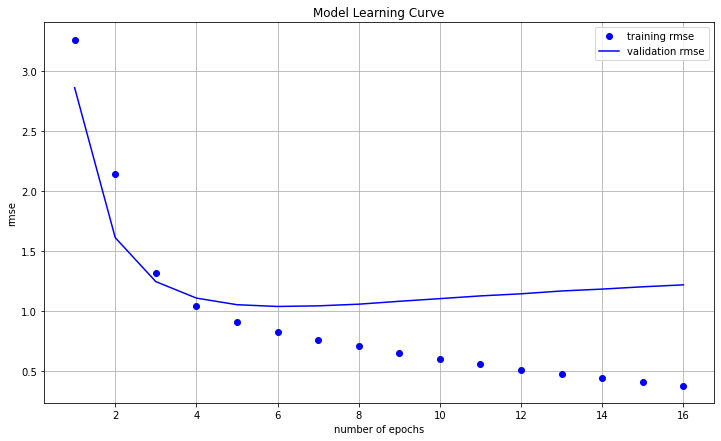

In [98]:
plot_learning_curve(history, 'rmse')

In [99]:
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

In [103]:

GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, './drive/MyDrive/model.hdf5')

predictions = GMF_model.predict([df_test["user index"].astype(np.int).values, df_test["movie index"].astype(np.int).values])

error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 1.057


In [107]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
   
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) 
    
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    
    model = Model([user_input, item_input], prediction)
    return model
    

In [108]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        44512       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 32)        267296      ['item_input[0][0]']             
                                                                                           

In [109]:

BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                      outputs=df_train.rating.values)

Epoch 1/30
868/868 [==============================] - 8s 7ms/step - loss: 1.8186 - mean_squared_error: 1.8186 - rmse: 1.1998 - val_loss: 0.9030 - val_mean_squared_error: 0.9030 - val_rmse: 0.9459
Epoch 2/30
868/868 [==============================] - 7s 8ms/step - loss: 0.7986 - mean_squared_error: 0.7986 - rmse: 0.8890 - val_loss: 0.8772 - val_mean_squared_error: 0.8772 - val_rmse: 0.9320
Epoch 3/30
868/868 [==============================] - 8s 9ms/step - loss: 0.7199 - mean_squared_error: 0.7199 - rmse: 0.8435 - val_loss: 0.8724 - val_mean_squared_error: 0.8724 - val_rmse: 0.9291
Epoch 4/30
868/868 [==============================] - 8s 9ms/step - loss: 0.6371 - mean_squared_error: 0.6371 - rmse: 0.7932 - val_loss: 0.9077 - val_mean_squared_error: 0.9077 - val_rmse: 0.9472
Epoch 5/30
868/868 [==============================] - 8s 9ms/step - loss: 0.5410 - mean_squared_error: 0.5410 - rmse: 0.7304 - val_loss: 0.9731 - val_mean_squared_error: 0.9731 - val_rmse: 0.9809
Epoch 6/30
868/868 [

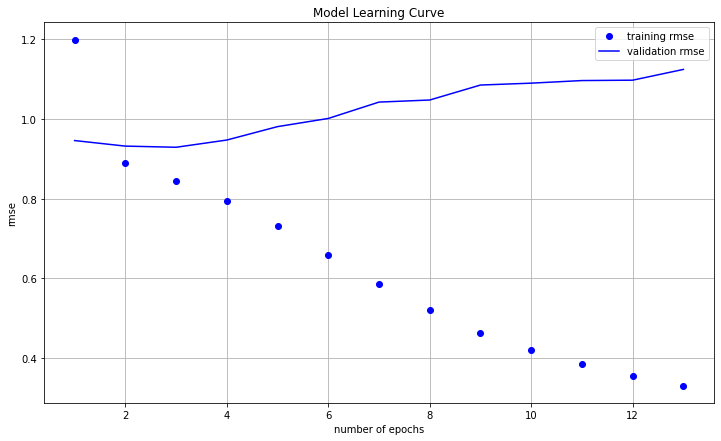

In [110]:
plot_learning_curve(history, 'rmse')

In [114]:

MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, './drive/MyDrive/model.hdf5')
predictions = MLP_model.predict([df_test["user index"].values.astype(np.int), df_test["movie index"].values.astype(np.int)])
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9458


In [115]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) 
   
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

  
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    
    model = Model([user_input, item_input], prediction)
    
    return model

In [116]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_embedding (Embedding)  (None, 1, 32)       44512       ['user_input[0][0]']             
                                                                                                  
 mlp_item_embedding (Embedding)  (None, 1, 32)       267296      ['item_input[0][0]']             
                                                                                           

In [117]:

BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25


history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train["user index"].values.astype(np.int), df_train["movie index"].values.astype(np.int)],
                      outputs=df_train.rating.values)

Epoch 1/30
868/868 [==============================] - 12s 12ms/step - loss: 1.7624 - mean_squared_error: 1.7624 - rmse: 1.1856 - val_loss: 0.8938 - val_mean_squared_error: 0.8938 - val_rmse: 0.9407
Epoch 2/30
868/868 [==============================] - 10s 12ms/step - loss: 0.7900 - mean_squared_error: 0.7900 - rmse: 0.8846 - val_loss: 0.8755 - val_mean_squared_error: 0.8755 - val_rmse: 0.9308
Epoch 3/30
868/868 [==============================] - 10s 12ms/step - loss: 0.5931 - mean_squared_error: 0.5931 - rmse: 0.7656 - val_loss: 0.9194 - val_mean_squared_error: 0.9194 - val_rmse: 0.9537
Epoch 4/30
868/868 [==============================] - 10s 11ms/step - loss: 0.3572 - mean_squared_error: 0.3572 - rmse: 0.5933 - val_loss: 0.9904 - val_mean_squared_error: 0.9904 - val_rmse: 0.9896
Epoch 5/30
868/868 [==============================] - 10s 12ms/step - loss: 0.2143 - mean_squared_error: 0.2143 - rmse: 0.4586 - val_loss: 1.0596 - val_mean_squared_error: 1.0596 - val_rmse: 1.0233
Epoch 6/30

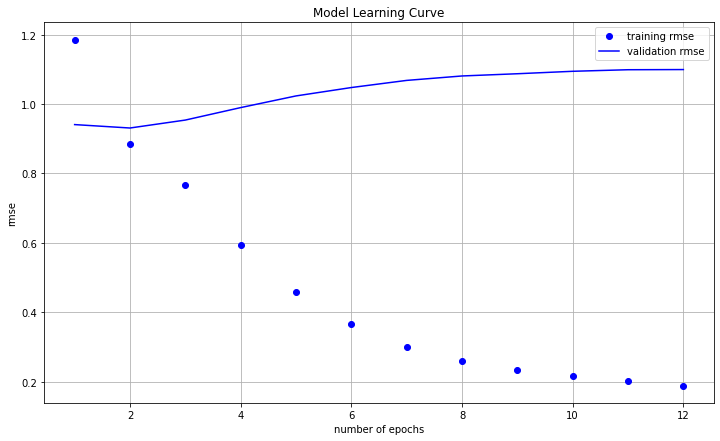

In [118]:
plot_learning_curve(history, 'rmse')

In [120]:

NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, './drive/MyDrive/model.hdf5')
predictions = NeuMF_model.predict([df_test["user index"].values.astype(np.int), df_test["movie index"].values.astype(np.int)])
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9497
